# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='C:/Users/Omarf/Documents/JupyterWS/p2_continuous-control/Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
#Import utilities
from collections import deque
import matplotlib.pyplot as plt
import time
import torch


#Agent related imports
import ddpg_agent
from ddpg_agent import Agent

In [6]:
#Create agent
agent = Agent(state_size, action_size, random_seed=0)

DDPG Agent hyperparameters:
	batch size: 		     128
	buffer size: 		  100000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999

Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_feat

In [7]:
def ddpg(n_episodes=2000, max_t=1000):
    
    scores = []
    average_score = []
    
    for i_episode in range(1, n_episodes+1):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        agent.noise.reset()
        scores_per_episode = np.zeros(1)

        
        for t in range(1, max_t+1):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            #done = env_info.local_done
            
            for (state, action, reward, next_state) in zip(states, actions, rewards, next_states):
                agent.step(state, action, reward, next_state)
                
            
            states = next_states
            scores_per_episode += rewards
            
            #if done:
            #   break 

        scores.append(scores_per_episode.tolist())
        average_score.append(np.mean(scores[-100:], axis=0))
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, average_score[-1].mean(),  scores_per_episode.mean()))
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
 
        if  average_score[-1].mean() >= 30.0 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, average_score[-1].mean()))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores ,average_score

scores , average_score = ddpg()

Episode 1	Average Score: 0.00	Score: 0.00
Episode 2	Average Score: 0.00	Score: 0.00
Episode 3	Average Score: 0.00	Score: 0.00
Episode 4	Average Score: 0.00	Score: 0.00
Episode 5	Average Score: 0.00	Score: 0.00
Episode 6	Average Score: 0.23	Score: 1.36
Episode 7	Average Score: 0.20	Score: 0.05
Episode 8	Average Score: 0.29	Score: 0.94
Episode 9	Average Score: 0.36	Score: 0.87
Episode 10	Average Score: 0.46	Score: 1.39
Episode 11	Average Score: 0.45	Score: 0.35
Episode 12	Average Score: 0.45	Score: 0.39
Episode 13	Average Score: 0.45	Score: 0.52
Episode 14	Average Score: 0.46	Score: 0.63
Episode 15	Average Score: 0.43	Score: 0.00
Episode 16	Average Score: 0.41	Score: 0.00
Episode 17	Average Score: 0.39	Score: 0.07
Episode 18	Average Score: 0.36	Score: 0.00
Episode 19	Average Score: 0.37	Score: 0.41
Episode 20	Average Score: 0.42	Score: 1.51
Episode 21	Average Score: 0.46	Score: 1.25
Episode 22	Average Score: 0.49	Score: 1.12
Episode 23	Average Score: 0.57	Score: 2.21
Episode 24	Average S

Episode 190	Average Score: 3.17	Score: 8.28
Episode 191	Average Score: 3.19	Score: 3.07
Episode 192	Average Score: 3.21	Score: 2.24
Episode 193	Average Score: 3.23	Score: 3.02
Episode 194	Average Score: 3.24	Score: 1.91
Episode 195	Average Score: 3.24	Score: 2.24
Episode 196	Average Score: 3.31	Score: 6.87
Episode 197	Average Score: 3.38	Score: 7.24
Episode 198	Average Score: 3.41	Score: 4.09
Episode 199	Average Score: 3.43	Score: 2.78
Episode 200	Average Score: 3.47	Score: 6.86
Episode 201	Average Score: 3.51	Score: 6.92
Episode 202	Average Score: 3.57	Score: 8.13
Episode 203	Average Score: 3.60	Score: 6.47
Episode 204	Average Score: 3.64	Score: 4.74
Episode 205	Average Score: 3.71	Score: 8.03
Episode 206	Average Score: 3.74	Score: 5.49
Episode 207	Average Score: 3.81	Score: 9.67
Episode 208	Average Score: 3.82	Score: 2.39
Episode 209	Average Score: 3.81	Score: 1.51
Episode 210	Average Score: 3.79	Score: 2.13
Episode 211	Average Score: 3.82	Score: 5.43
Episode 212	Average Score: 3.82	

Episode 376	Average Score: 7.29	Score: 8.78
Episode 377	Average Score: 7.32	Score: 12.12
Episode 378	Average Score: 7.31	Score: 3.58
Episode 379	Average Score: 7.28	Score: 4.57
Episode 380	Average Score: 7.31	Score: 8.58
Episode 381	Average Score: 7.32	Score: 7.72
Episode 382	Average Score: 7.33	Score: 6.48
Episode 383	Average Score: 7.31	Score: 4.85
Episode 384	Average Score: 7.30	Score: 5.99
Episode 385	Average Score: 7.29	Score: 9.75
Episode 386	Average Score: 7.37	Score: 12.46
Episode 387	Average Score: 7.32	Score: 4.86
Episode 388	Average Score: 7.28	Score: 5.71
Episode 389	Average Score: 7.26	Score: 7.31
Episode 390	Average Score: 7.19	Score: 5.24
Episode 391	Average Score: 7.25	Score: 10.53
Episode 392	Average Score: 7.25	Score: 7.30
Episode 393	Average Score: 7.30	Score: 6.56
Episode 394	Average Score: 7.32	Score: 7.28
Episode 395	Average Score: 7.31	Score: 6.32
Episode 396	Average Score: 7.31	Score: 7.14
Episode 397	Average Score: 7.29	Score: 6.51
Episode 398	Average Score: 7.

Episode 560	Average Score: 10.97	Score: 11.21
Episode 561	Average Score: 10.93	Score: 5.63
Episode 562	Average Score: 11.04	Score: 14.58
Episode 563	Average Score: 11.02	Score: 9.93
Episode 564	Average Score: 11.08	Score: 9.10
Episode 565	Average Score: 11.04	Score: 7.51
Episode 566	Average Score: 11.08	Score: 14.40
Episode 567	Average Score: 11.00	Score: 4.02
Episode 568	Average Score: 11.00	Score: 7.00
Episode 569	Average Score: 11.12	Score: 16.40
Episode 570	Average Score: 11.09	Score: 6.61
Episode 571	Average Score: 10.99	Score: 7.07
Episode 572	Average Score: 11.01	Score: 14.12
Episode 573	Average Score: 11.08	Score: 13.92
Episode 574	Average Score: 11.01	Score: 7.86
Episode 575	Average Score: 11.03	Score: 11.49
Episode 576	Average Score: 11.00	Score: 9.35
Episode 577	Average Score: 10.93	Score: 5.46
Episode 578	Average Score: 10.93	Score: 8.87
Episode 579	Average Score: 11.03	Score: 16.08
Episode 580	Average Score: 11.01	Score: 9.53
Episode 581	Average Score: 10.99	Score: 7.52
Ep

Episode 740	Average Score: 18.42	Score: 24.99
Episode 741	Average Score: 18.56	Score: 22.43
Episode 742	Average Score: 18.56	Score: 23.97
Episode 743	Average Score: 18.50	Score: 17.42
Episode 744	Average Score: 18.53	Score: 20.49
Episode 745	Average Score: 18.50	Score: 12.46
Episode 746	Average Score: 18.66	Score: 29.37
Episode 747	Average Score: 18.81	Score: 30.89
Episode 748	Average Score: 18.69	Score: 13.87
Episode 749	Average Score: 18.66	Score: 15.17
Episode 750	Average Score: 18.79	Score: 26.86
Episode 751	Average Score: 18.74	Score: 19.71
Episode 752	Average Score: 18.84	Score: 26.23
Episode 753	Average Score: 18.98	Score: 21.02
Episode 754	Average Score: 19.06	Score: 26.00
Episode 755	Average Score: 19.28	Score: 28.88
Episode 756	Average Score: 19.42	Score: 31.52
Episode 757	Average Score: 19.65	Score: 35.13
Episode 758	Average Score: 19.77	Score: 30.10
Episode 759	Average Score: 19.99	Score: 35.84
Episode 760	Average Score: 20.11	Score: 34.24
Episode 761	Average Score: 20.11	S

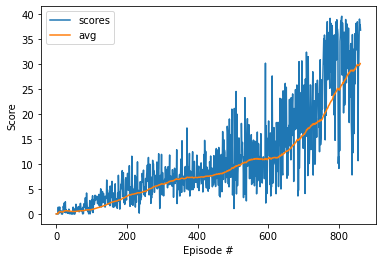

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(average_score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['scores','avg'])
plt.show()

In [15]:
# load the weights from file
checkpoint = torch.load('checkpoint.pt', map_location='cpu')
agent = Agent(state_size, action_size, random_seed=0)
agent.actor_local.load_state_dict(checkpoint['actor_dict'])
agent.critic_local.load_state_dict(checkpoint['critic_dict'])

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]       # get the next state
    
    for j in range(200):
        action = agent.act(state).astype(int)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]   # get the next state
        done = env_info.local_done[0]             # see if episode has finished
        if done:
            break

DDPG Agent hyperparameters:
	batch size: 		     128
	buffer size: 		  100000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999

Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=4, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=33, out_features=400, bias=True)
  (1): Linear(in_features=404, out_feat

In [21]:
env.close()